# House pricing on the basis of square footage and realtor assesment

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

## Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [346]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()
print(df.head())
df.columns

   index  Unnamed: 0          id             date     price  bedrooms  \
0     52       16254  9265410010  20150203T000000  212000.0         3   
1     91       18668  5490700035  20140807T000000  325000.0         4   
2     76        8353  1862400215  20150120T000000  775000.0         3   
3     53       16196  7527410080  20140602T000000  585083.0         5   
4     71        8520  8132700150  20140503T000000  553000.0         2   

   bathrooms  sqft_living  sqft_lot  floors  ...  grade  sqft_above  \
0       1.75         1470      8350     1.0  ...      7        1470   
1       1.50         1870      7220     2.0  ...      7        1870   
2       2.50         2480      5007     2.0  ...      8        1960   
3       2.75         2910     36250     1.0  ...      8        1590   
4       1.00          900      5000     1.0  ...      7         900   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1990             0    98001  47.2587 -122

Index(['index', 'Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [369]:

mean_sqft_living = (df['sqft_living']).mean()
mean_grade = (df['grade']).mean()
sd_sqft_living = (df['sqft_living']).std()
print(sd_sqft_living)
print(mean_sqft_living)
sd_grade = (df['grade']).std()
sqft_living_standardized = ((df['sqft_living']).copy())
price_standardized = ((df['price']).copy())
sqft_living_centered = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
print(sqft_living_standardized)
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living
    grade_standardized[i] = (df['grade'][i]-mean_grade)/sd_grade
    price_standardized[i] = (df['price'][i]-(df['price']).mean())/(df['price']).std()
print(sqft_living_standardized.head())
print(sqft_living_standardized[0])
# print(grade_standardized)

864.2521496541492
2153.86
0     1470
1     1870
2     2480
3     2910
4      900
      ... 
95    1420
96    2930
97    2620
98    3550
99    2240
Name: sqft_living, Length: 100, dtype: int64
0   -0.791274
1   -0.328446
2    0.377367
3    0.874907
4   -1.450803
Name: sqft_living, dtype: float64
-0.7912737044086761


In [348]:
mean_price = (df['price']).mean()
print(mean_price)

541517.08


## Model 1

### Prior

The parameters for the prior have been selected on the basis of a 

The prior has is fed 

In [350]:
sqft_living_centered

0     -683.86
1     -283.86
2      326.14
3      756.14
4    -1253.86
       ...   
95    -733.86
96     776.14
97     466.14
98    1396.14
99      86.14
Name: sqft_living, Length: 100, dtype: float64

In [351]:
# tutaj się zastanawiam czy wkładamy te dane zestandaryzowane czy zwykłe,
# ale jak da się te zwykłe to wygląda to lepiej
# nie wiem kurwa przecież nie wkładamy tutaj nigdzie tych standaryzowanych danych a jakoś to wyglada lepiej
# ja już nie wiem o co chodzi
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
# sqft_linspace = np.linspace(sqft_living_standardized.min(), sqft_living_standardized.max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


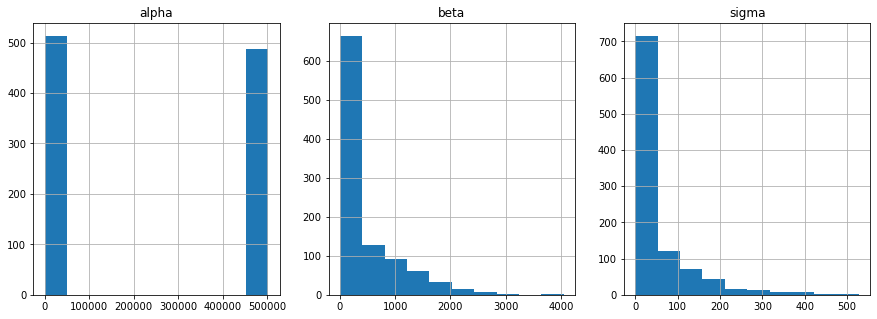

,mean,sd,hdi_3%,hdi_97%
alpha,243502.15,250043.75,0.0,501207.00
beta,393.32,592.98,0.0,1549.82
sigma,46.96,80.50,0.0,187.40


In [352]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

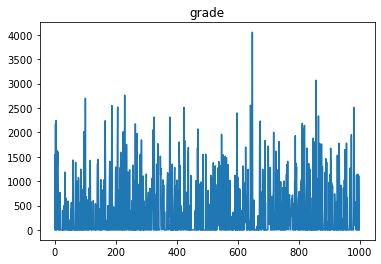

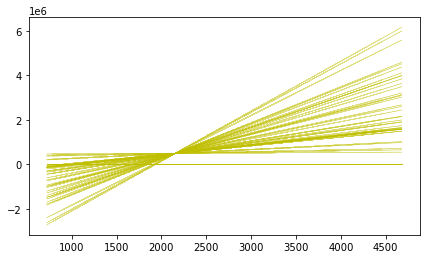

In [353]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

plt.plot(beta_sim)
plt.title("grade")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
# axes.hlines([0,272],xmin=df['sqft_living'].min(),xmax=df['sqft_living'].max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(df['sqft_living'],alpha_sim[i]+beta_sim[i]*sqft_living_centered, color = 'y',alpha=0.5,linewidth=0.5)

# plt.ylim(ymax = 1e7, ymin = -100)



## Model 1 Posterior

In [354]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


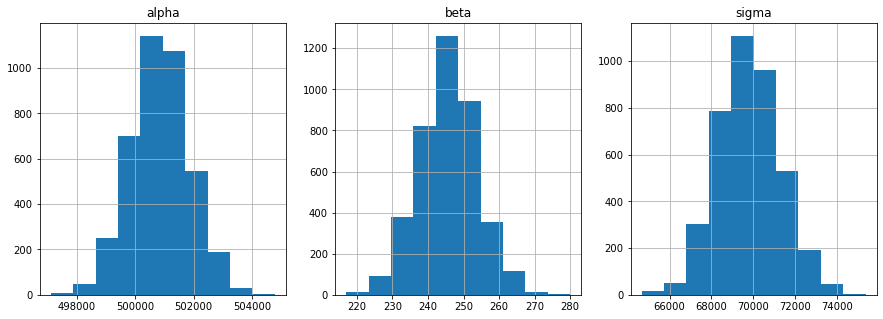

,mean,sd,hdi_3%,hdi_97%
alpha,500852.80,1011.76,498993.00,502754.00
beta,245.57,8.19,229.03,260.18
sigma,69796.48,1483.44,67074.50,72548.30


In [355]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

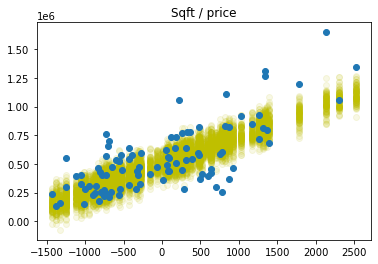

In [356]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_centered, df["price"])

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

### Prior predictive check

In [373]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max())
grade_linspace = np.linspace(grade_standardized.min(),grade_standardized.max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_linspace}
two_params_ppc = CmdStanModel(stan_file='CommandFiles/two_params_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


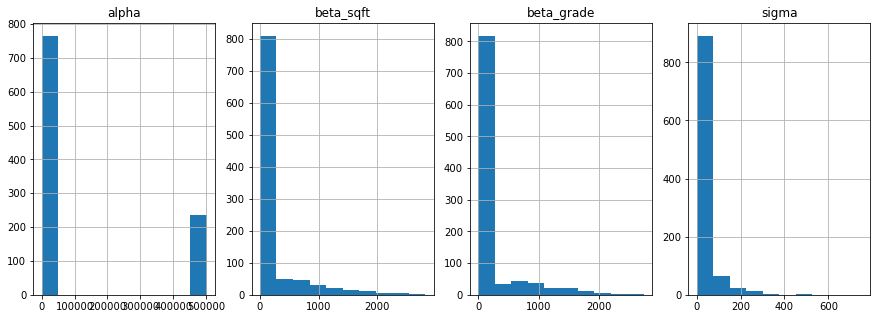

,mean,sd,hdi_3%,hdi_97%
alpha,500852.80,1011.76,498993.00,502754.00
beta,245.57,8.19,229.03,260.18
sigma,69796.48,1483.44,67074.50,72548.30


In [372]:
alpha_sim = two_params_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_ppc_simulated.stan_variable('sigma')
# price_sim = two_params_ppc_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

In [378]:
data = {'N': len(sqft_living_standardized),
        'sqft_living': sqft_living_standardized,
        'grade': grade_standardized,
        'price': price_standardized}
two_params = CmdStanModel(stan_file='CommandFiles/two_params.stan')
two_params_simulated = two_params.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


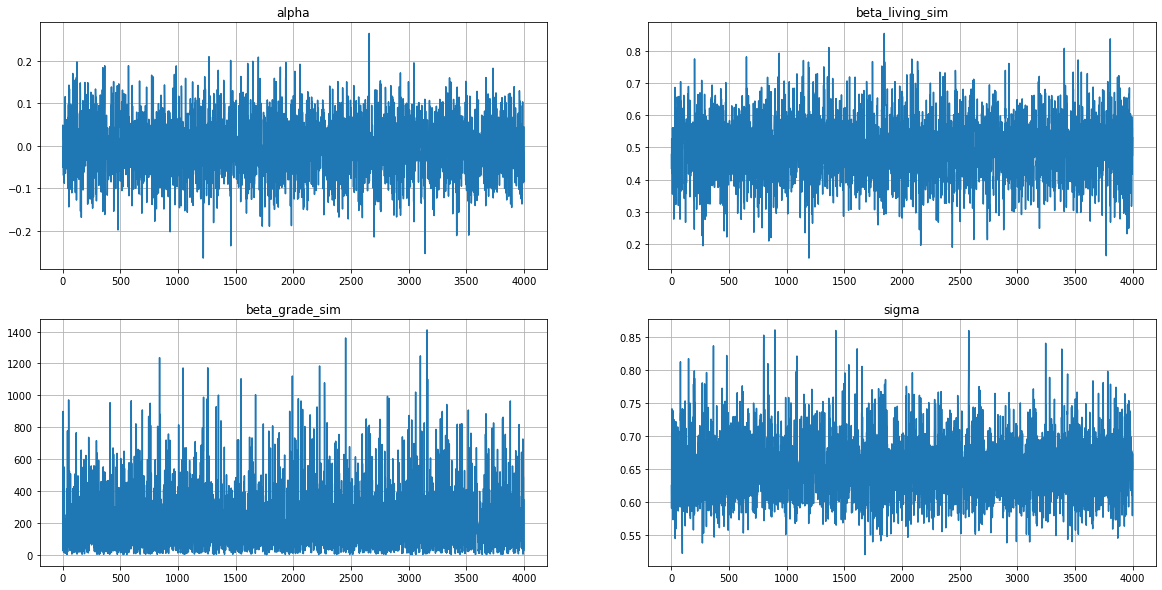

,mean,sd,hdi_3%,hdi_97%
alpha,-0.00,0.07,-0.13,0.12
beta_sqft_living,0.49,0.09,0.31,0.67
beta_grade,0.33,0.09,0.15,0.50
sigma,0.65,0.05,0.57,0.74


In [379]:
alpha_sim = two_params_simulated.stan_variable('alpha')
beta_living_sim = two_params_simulated.stan_variable('beta_sqft_living')
beta_grade_sim = two_params_simulated.stan_variable('beta_grade')
sigma_sim = two_params_simulated.stan_variable('sigma')
price_sim = two_params_simulated.stan_variable('prices')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_living_sim')
axs[1][0].plot(beta_lot_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_grade_sim')
axs[1][1].plot(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()

az.summary(two_params_simulated,var_names=['alpha','beta_sqft_living', 'beta_grade','sigma'],round_to=2,kind='stats')

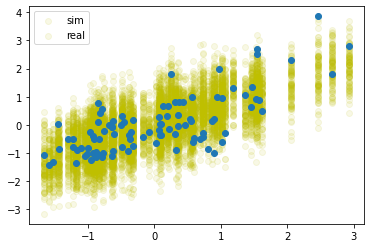

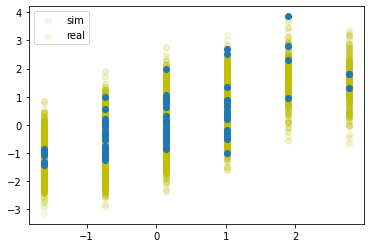

In [381]:
price_sim = two_params_simulated.stan_variable('prices')


for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_standardized,price_standardized)
plt.legend(["sim", "real"])
plt.show()

for i in range(100):
    plt.scatter(grade_standardized, price_sim[i], color="y", alpha=0.1)
plt.scatter(grade_standardized,price_standardized)
plt.legend(["sim", "real"])



In [382]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik") 
compare_dict = {"one_param_model": idata1, "two_param_model": idata2}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_model,0,-100.874068,4.595410,0.000000,1.0,8.767623,0.00000,False,log
one_param_model,1,-1618.310558,23.139643,1517.436489,0.0,69.290223,61.60474,True,log


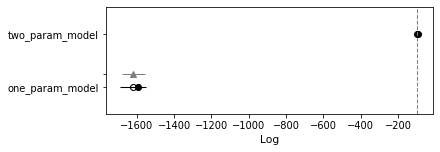

In [383]:
az.plot_compare(out_loo)
out_loo


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
two_param_model,0,-100.843530,4.564871,0.000000,1.000000e+00,8.755786,0.000000,True,log
one_param_model,1,-1617.823918,22.653004,1516.980388,1.854971e-09,69.061813,61.393374,True,log


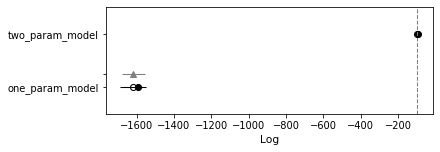

In [384]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.